# Interpolation of stellar spectra and templates

Within ASTRA, the individual Frame's and the Stellar templates have a common parent class:

```py 
from ASTRA.Components.Modelling import Spectral_Modelling
```

Due to the nature of ASTRA internals, the configurations from this parent class are not see through the *config_help* function when called on either of those two objects.

In [11]:
from ASTRA.Components.Modelling import Spectral_Modelling

Spectral_Modelling.config_help()

Configurations:

Name:: SAVE_DISK_SPACE
	Description:: Save disk space in the outputs if different than None
	Mandatory:: False
	Default value:: DISK_SAVE_MODE.DISABLED
	Constraints:: Value from list <<enum 'DISK_SAVE_MODE'>>
 
Name:: WORKING_MODE
	Description:: How to store the output files. If one-shot, overwrites all files, otherwise updates products
	Mandatory:: False
	Default value:: WORKING_MODE.ONE_SHOT
	Constraints:: Value from list <<enum 'WORKING_MODE'>>
 
Name:: INTERPOL_MODE
	Description:: None
	Mandatory:: False
	Default value:: SPECTRA_INTERPOL_MODE.SPLINES
	Constraints:: Value from list <<enum 'SPECTRA_INTERPOL_MODE'>>
 
Name:: SPLINE_TYPE
	Description:: None
	Mandatory:: False
	Default value:: SPLINE_INTERPOL_MODE.CUBIC_SPLINE
	Constraints:: Value from list <<enum 'SPLINE_INTERPOL_MODE'>>
 
Name:: INTERPOLATION_ERR_PROP
	Description:: None
	Mandatory:: False
	Default value:: INTERPOLATION_ERR_PROP.interpolation
	Constraints:: Value from list <<enum 'INTERPOLATION_ERR_PR

This parent class unlocks a common API for the interpolation of spectra (either in the form of a single observation or in the form of a stellar template).

This interface will run a serial set of operations:

- If configured to do so, smooth the stellar spectra before the interpolation
- Apply/remove a given RV shift to the wavelengths
- Interpolate the spectra and compute new flux uncertainties (based on configuration)
- If configured to do so, smooth the stellar spectra after the interpolation

This function does not compute the limits of interpolation (i.e., it **will** extrapolate if the *new_wavelengths* are outside the valid ranges of the underlying data)

2025-04-14 22:44:47.206 | INFO     | ASTRA.base_models.Frame:__init__:252 - Creating frame from: /home/amiguel/spectra_collection/ESPRESSO/proxima/r.ESPRE.2019-07-03T01:43:39.634_S2D_A.fits
2025-04-14 22:44:47.208 | WARNING  | ASTRA.Components.SpectrumComponent:regenerate_order_status:96 - Resetting order status of Frame - ESPRESSO
2025-04-14 22:44:47.224 | DEBUG    | ASTRA.base_models.Frame:assess_bad_orders:710 - Rejecting spectral orders
2025-04-14 22:44:47.227 | INFO     | ASTRA.base_models.Frame:assess_bad_orders:740 - Frame None rejected 37 orders for having SNR smaller than 5: 0-36
2025-04-14 22:44:47.229 | DEBUG    | ASTRA.base_models.Frame:load_S2D_data:861 - Opening the S2D arrays from r.ESPRE.2019-07-03T01:43:39.634_S2D_A.fits
2025-04-14 22:44:47.248 | WARNING  | ASTRA.Instruments.ESO_PIPELINE:load_ESO_DRS_S2D_data:327 - Not applying correction to blue-red flux balance!
2025-04-14 22:44:47.319 | DEBUG    | ASTRA.base_models.Frame:build_mask:627 - Cleaning wavelength regions 

(4486.688103074458, 4490.840682985041)

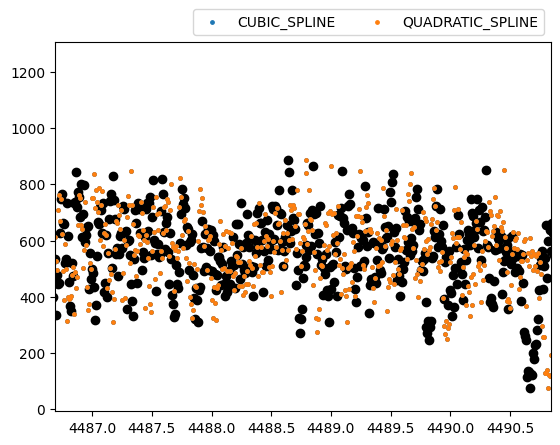

In [19]:
import matplotlib.pyplot as plt

from ASTRA.Instruments import ESPRESSO
from ASTRA.utils import choices

frame = ESPRESSO(file_path="/home/amiguel/spectra_collection/ESPRESSO/proxima/r.ESPRE.2019-07-03T01:43:39.634_S2D_A.fits",
                 user_configs={"INTERPOL_MODE": choices.SPECTRA_INTERPOL_MODE.SPLINES,
                               "SPLINE_INTERPOL_MODE": choices.SPLINE_INTERPOL_MODE.CUBIC_SPLINE
                               }
                 )
frame.generate_root_path("tmp")

spectral_order = 50 
wave, flux, err, mask = frame.get_data_from_spectral_order(order=spectral_order)

fig, axis = plt.subplots()
axis.scatter(wave[~mask], flux[~mask], color="black")

waves_to_interpol = wave[~mask][1000:1500]
for spline_mode in [choices.SPLINE_INTERPOL_MODE.CUBIC_SPLINE, choices.SPLINE_INTERPOL_MODE.QUADRATIC_SPLINE]:
    new_flux, new_err = frame.interpolate_spectrum_to_wavelength(order = 50,
                                            new_wavelengths=waves_to_interpol,
                                            shift_RV_by=10,
                                            RV_shift_mode="apply",)
    
    axis.scatter(waves_to_interpol, new_flux, label=spline_mode.name, s=6)
axis.legend(ncol=3, loc=4, bbox_to_anchor=(1,1))
axis.set_xlim([waves_to_interpol[0], waves_to_interpol[-1]])